# Imports

In [1]:
from collections import defaultdict
import io
import os

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import PIL
import sklearn.datasets
import sklearn.preprocessing

import graphviz

# Parameters

In [2]:
n_points = 22
n_inliers = 10
n_outliers = 1
centers = [[2, 2], [-2, -2]]
cluster_std = [1, 1.5]

plots_dir = "./plots/"

# Helper Functions

In [3]:
def mkdirs(path):
    import os, errno
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

# iTree Definitions

## iTree_Node

In [4]:
class iTree_Node():
    def __init__(self, parent, XX, features, indices, random_state):
        super().__init__()
        vmin = XX.min(axis=0)
        vmax = XX.max(axis=0)
        diff = vmax - vmin
        test = diff > 0
        if not np.any(test):
            split_index = None
            split_value = None
        else:
            split_index = random_state.choice(indices[test])
            split_value = random_state.uniform(
                low=vmin[split_index],
                high=vmax[split_index]
            )
        self.parent = parent
        self.features = features
        self.vmin = vmin
        self.vmax = vmax
        self.split_index = split_index
        self.split_value = split_value
        self.count = len(XX)
        if split_index is None:
            self.left = None
            self.right = None
        else:
            self.left = iTree_Node(
                self,
                XX=XX[XX[:,split_index] <= split_value],
                features=features,
                indices=indices,
                random_state=random_state
            )
            self.right = iTree_Node(
                self,
                XX=XX[XX[:,split_index] > split_value],
                features=features,
                indices=indices,
                random_state=random_state
            )
    
    def __str__(self):
        if self.parent is None:
            return f"Root ({self.count})"
        else:
            compare = "<=" if self.parent.left == self else ">"
            feature = self.features[self.parent.split_index]
            threshold = self.parent.split_value
            count = self.count
            return f"{feature} {compare} {threshold} ({count})"
    
    def __hash__(self):
        return id(self)

## iTree

In [5]:
class iTree():
    def __init__(self, XX, features=None, random_state=None):
        super().__init__()
        XX = np.asarray(XX)
        feature_indices = np.arange(XX.shape[1])
        if features is None:
            features = feature_indices
        features = np.asarray(features)
        assert(XX.shape[1] == len(features))
        self.features = features
        self.root = iTree_Node(None, XX, features, feature_indices, random_state)
    
    def _traverse(self, node, tree):
        if node.split_index is not None:
            tree.setdefault(node, []).append(node.left)
            self._traverse(node.left, tree)
            
            tree.setdefault(node, []).append(node.right)
            self._traverse(node.right, tree)
            
    def _print_tree(self, output, parent, grandparent, tree, prefix, indent_width=2):
        output.write(str(parent) + "\n")
        if parent in tree:
            for ii,child in enumerate(tree[parent],1):
                if ii != len(tree[parent]):
                    s1, s2 = u"\u2560", u"\u2551"
                else:
                    s1, s2 = u"\u255A", " " 
                s3 = u"\u2550" if tree.get(child) == None else u"\u2566"
                output.write(u"{}{}{}{}".format(prefix, s1, u"\u2550" * indent_width, s3))
                new_prefix = u"{}{}{}".format(prefix, s2, " " * indent_width)
                self._print_tree(output, child, parent, tree, new_prefix, indent_width)
    
    def __str__(self):
        tree = {}
        self._traverse(i_tree.root, tree)
        output = io.StringIO()
        self._print_tree(
            output=output,
            parent=i_tree.root,
            grandparent=None,
            tree=tree,
            prefix="",
        )
        return output.getvalue()

## iTree2Digraph

In [6]:
def iTree2Digraph(i_tree, hidden=set(), node_attrs=dict()):
    def _traverse(node):
        if node.split_index is not None:
            parent = hex(id(node))
            attrs = dict(
                label=f"{node.features[node.split_index]}",
                color="white" if parent in hidden else "black",
                fontcolor="white" if parent in hidden else "black"
            )
            attrs.update(node_attrs.get(parent, dict()))
            graph.node(parent, **attrs)
            
            left = hex(id(node.left))
            attrs = dict(
                label=f"<= {node.split_value:0.2f}",
                color="white" if parent in hidden or left in hidden else "black",
                fontcolor="white" if parent in hidden or left in hidden else "black"
            )
            graph.edge(parent, left, **attrs)
            _traverse(node.left)
            
            right = hex(id(node.right))
            attrs = dict(
                label=f"> {node.split_value:0.2f}",
                color="white" if parent in hidden or right in hidden else "black",
                fontcolor="white" if parent in hidden or right in hidden else "black",
            )
            graph.edge(parent, right, **attrs)
            _traverse(node.right)
        else:
            parent = hex(id(node))
            attrs = dict(
                label=f"{node.count}",
                color="white" if parent in hidden else "black",
                fontcolor="white" if parent in hidden else "black"
            )
            attrs.update(node_attrs.get(parent, dict()))
            graph.node(parent, **attrs)
        
    graph = graphviz.Digraph()
    _traverse(i_tree.root)
    return graph

# Data Generation

In [7]:
random = np.random.RandomState(0)

X_inliers, y_inliers = sklearn.datasets.make_blobs(
    n_samples=n_inliers,
    n_features=2,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random
)

X_outliers = random.uniform(size=(n_outliers,2))

X_extra, y_extra = sklearn.datasets.make_blobs(
    n_samples=n_points,
    n_features=2,
    centers=centers,
    cluster_std=cluster_std,
    random_state=42
)

X_full = np.vstack([
    sklearn.preprocessing.MinMaxScaler((0.25,0.75)).fit_transform(X_extra),
    sklearn.preprocessing.MinMaxScaler((0.25,0.75)).fit_transform(X_inliers),
    sklearn.preprocessing.MinMaxScaler((0.1,0.9)).fit_transform(X_outliers),
])

X_sample = X_full[n_points:]
print(X_full.shape)
print(X_sample.shape)

(33, 2)
(11, 2)


# Visualization

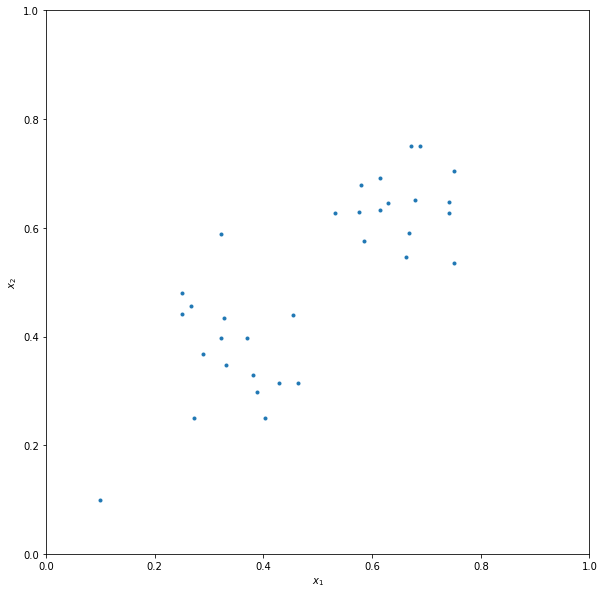

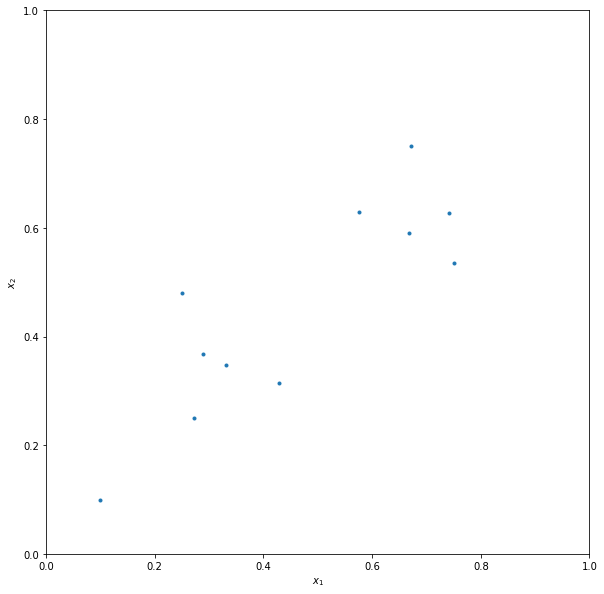

In [8]:
fig,ax = plt.subplots(figsize=(16,10))
ax.scatter(*X_full.T, marker=".")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("$x_{1}$")
ax.set_ylabel("$x_{2}$")
ax.set_aspect("equal")
plt.show()

fig,ax = plt.subplots(figsize=(16,10))
ax.scatter(*X_sample.T, marker=".")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("$x_{1}$")
ax.set_ylabel("$x_{2}$")
ax.set_aspect("equal")
plt.show()

# iTree

Root (11)
╠══╦X₁ <= 0.5014630730993201 (6)
║  ╠═══X₁ <= 0.1731795129649037 (1)
║  ╚══╦X₁ > 0.1731795129649037 (5)
║     ╠══╦X₂ <= 0.46721367791330815 (4)
║     ║  ╠═══X₂ <= 0.3032871424803166 (1)
║     ║  ╚══╦X₂ > 0.3032871424803166 (3)
║     ║     ╠═══X₂ <= 0.3381833496202014 (1)
║     ║     ╚══╦X₂ > 0.3381833496202014 (2)
║     ║        ╠═══X₂ <= 0.3493897810272098 (1)
║     ║        ╚═══X₂ > 0.3493897810272098 (1)
║     ╚═══X₂ > 0.46721367791330815 (1)
╚══╦X₁ > 0.5014630730993201 (5)
   ╠══╦X₂ <= 0.6787160016435726 (4)
   ║  ╠═══X₂ <= 0.5518508963416427 (1)
   ║  ╚══╦X₂ > 0.5518508963416427 (3)
   ║     ╠═══X₁ <= 0.5969398624469965 (1)
   ║     ╚══╦X₁ > 0.5969398624469965 (2)
   ║        ╠═══X₁ <= 0.7126012665052167 (1)
   ║        ╚═══X₁ > 0.7126012665052167 (1)
   ╚═══X₂ > 0.6787160016435726 (1)



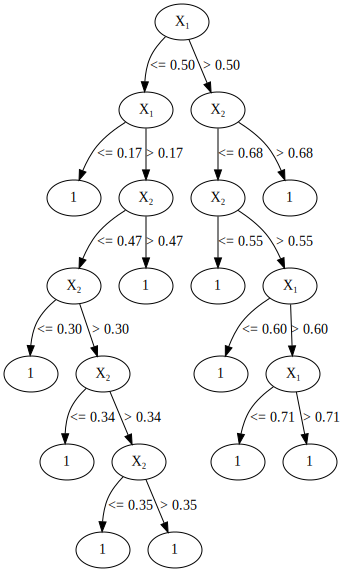

In [9]:
i_tree = iTree(X_sample, features=["X₁", "X₂"], random_state=random)
print(i_tree)
display(
    iTree2Digraph(i_tree)
)

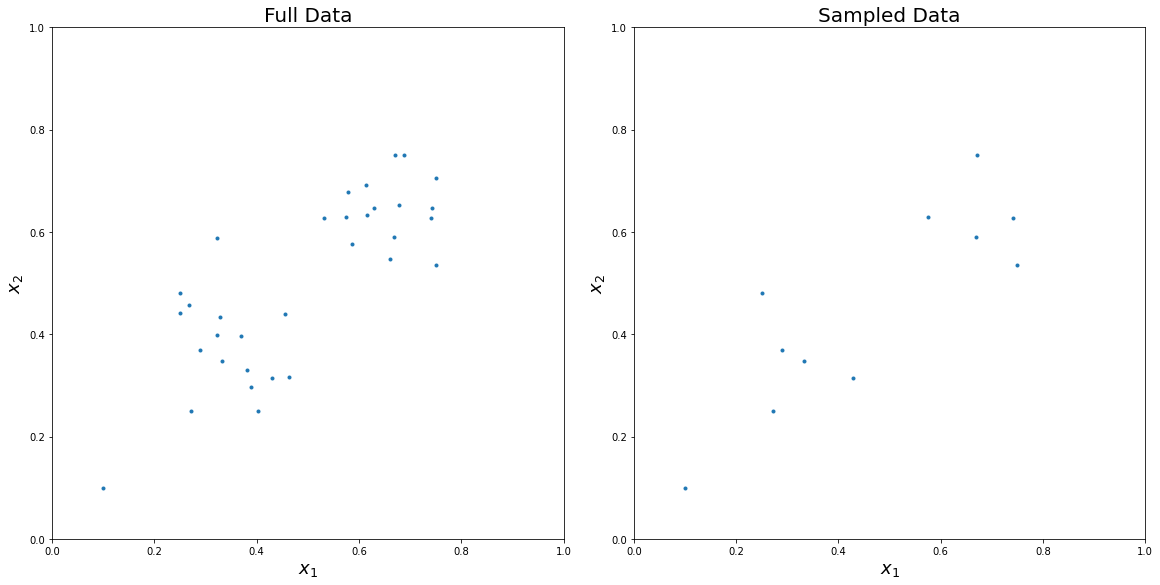

./plots/000


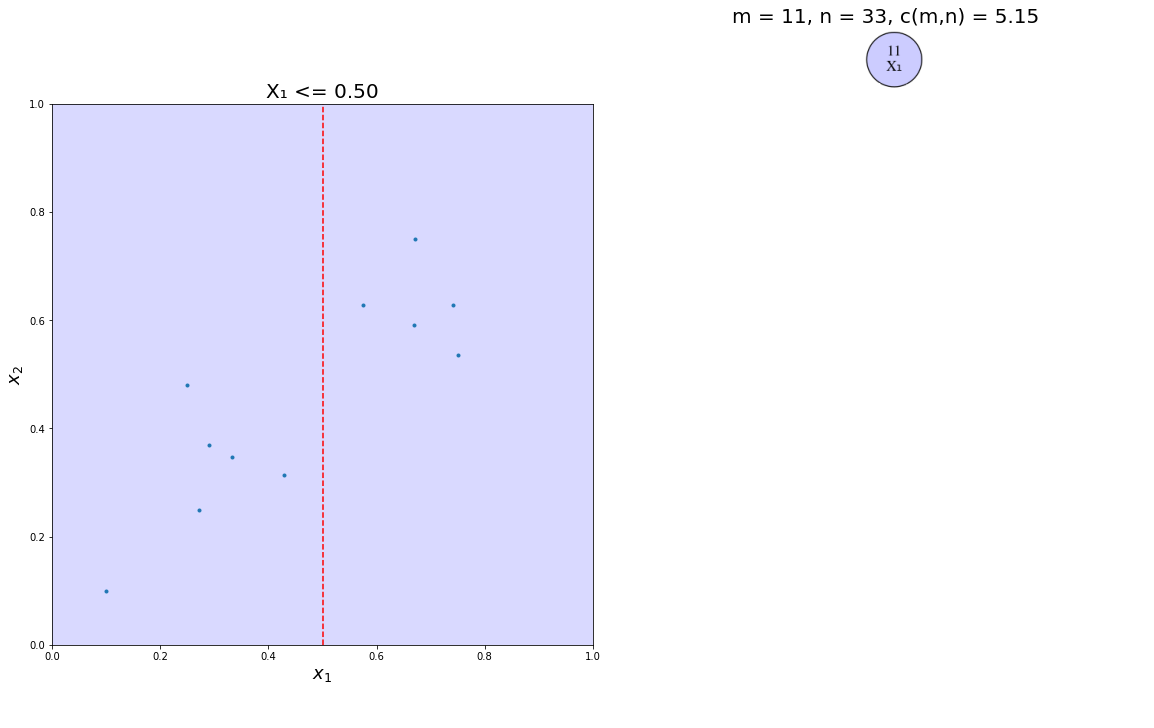

./plots/001


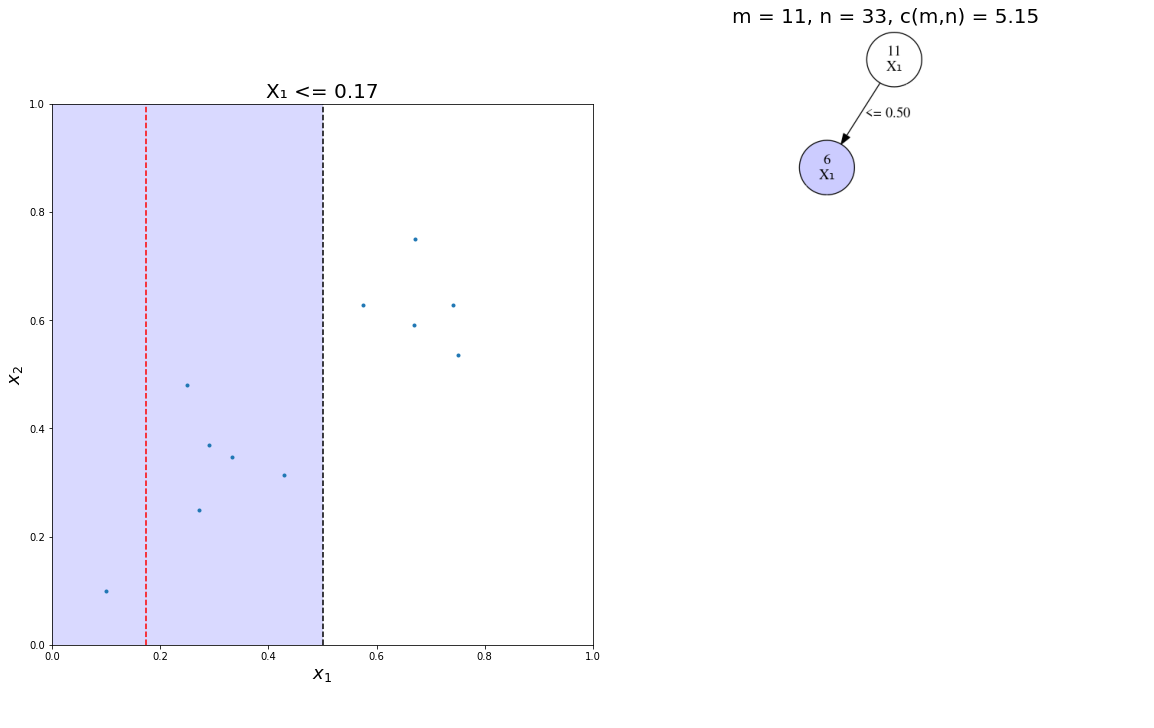

./plots/002


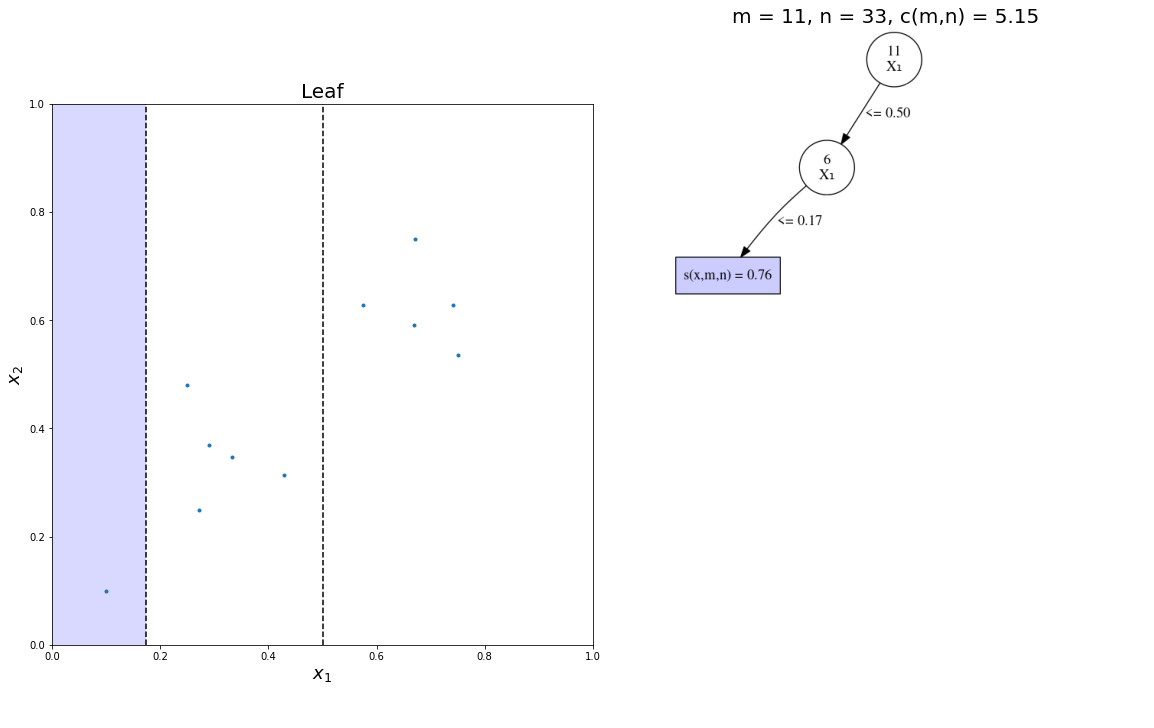

./plots/003


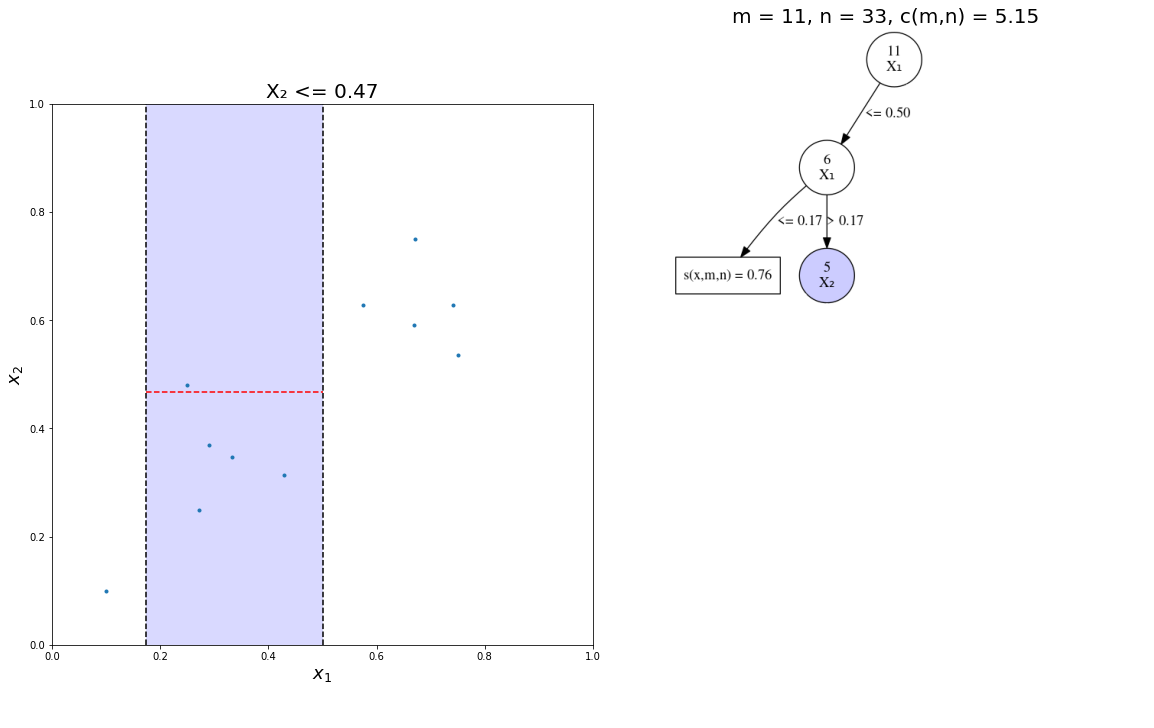

./plots/004


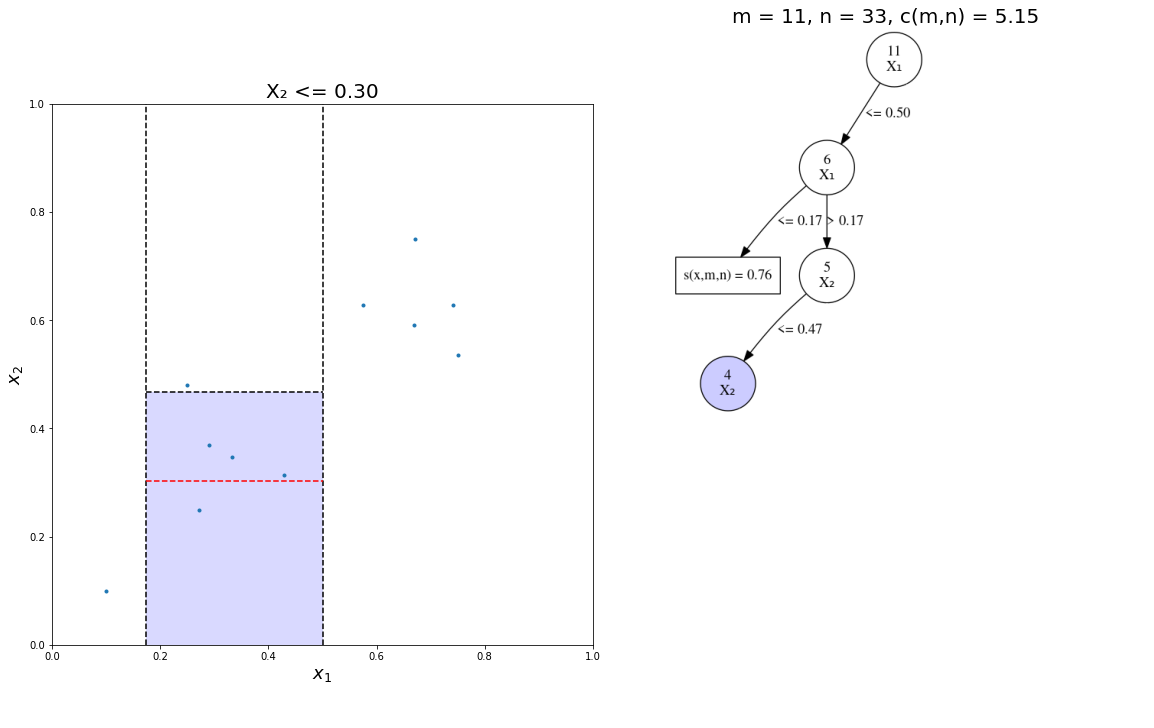

./plots/005


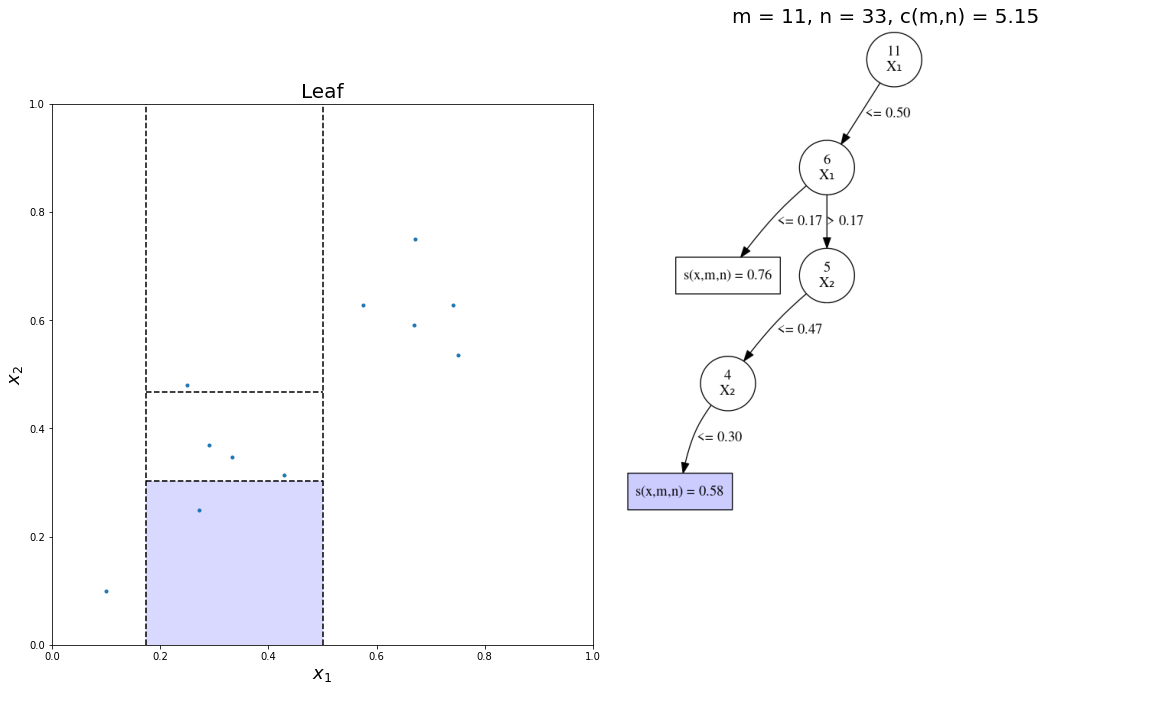

./plots/006


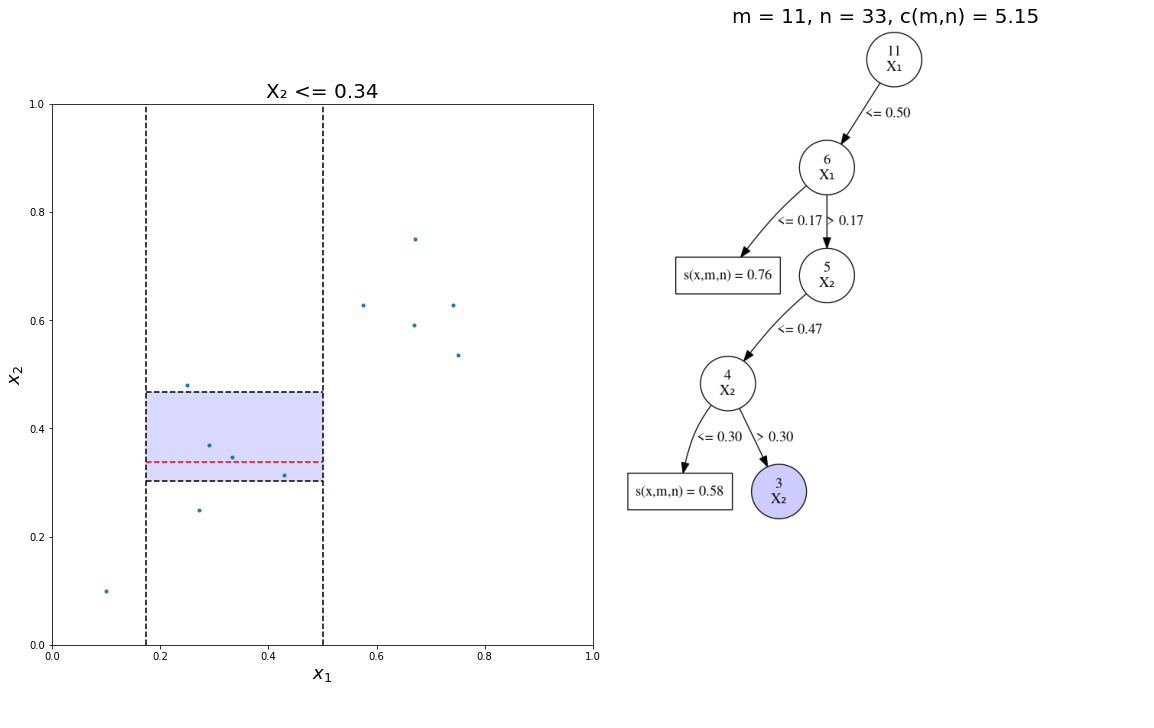

./plots/007


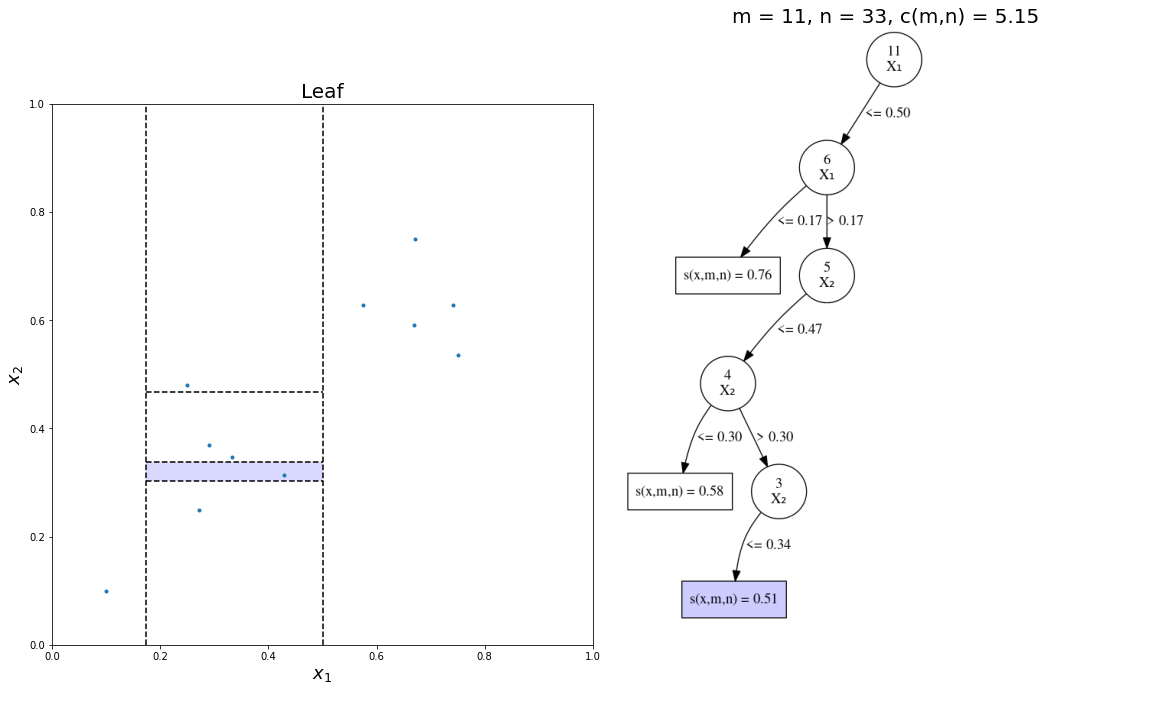

./plots/008


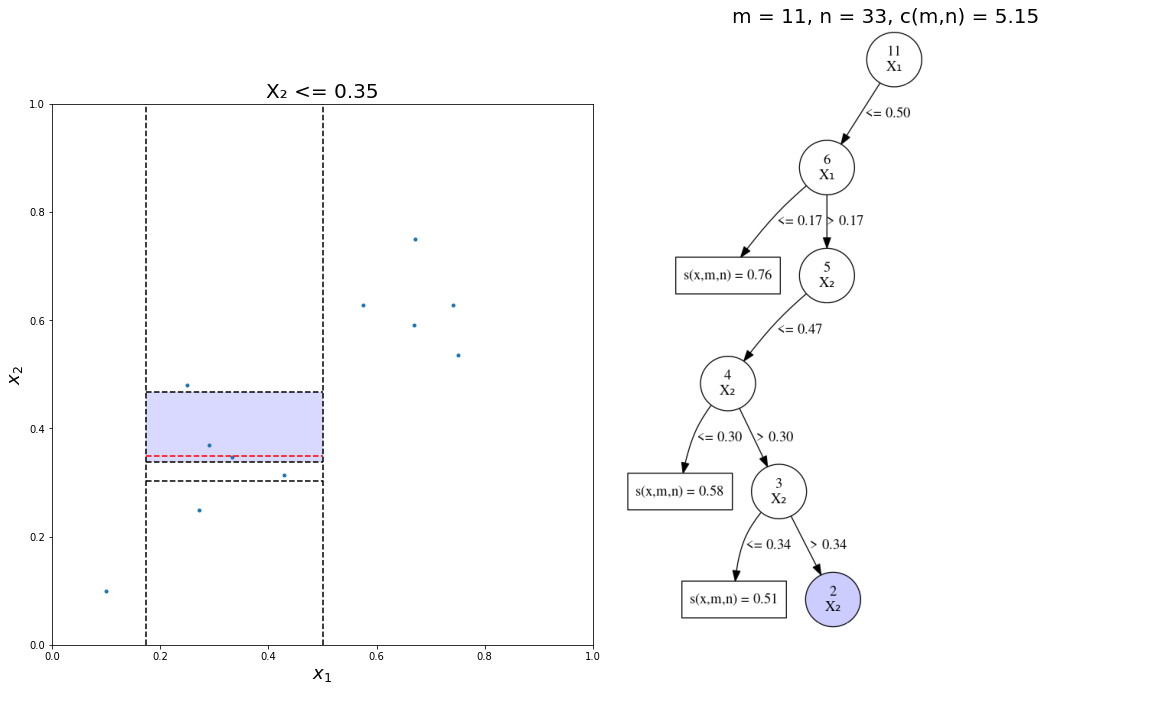

./plots/009


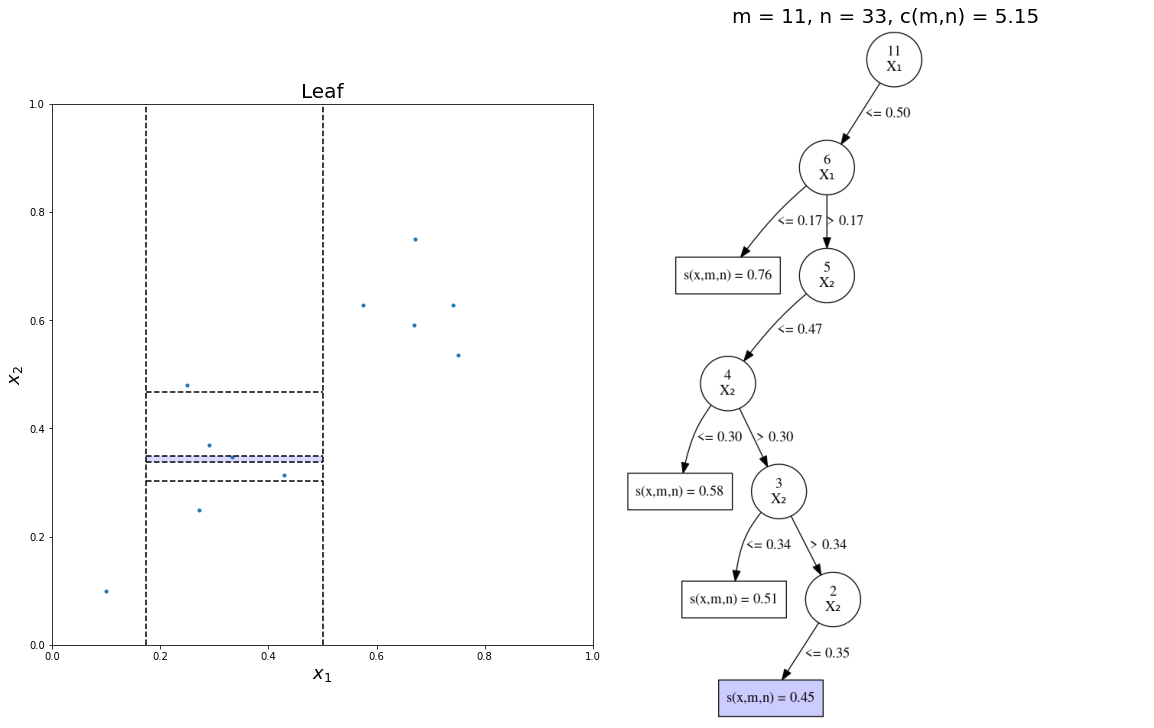

./plots/010


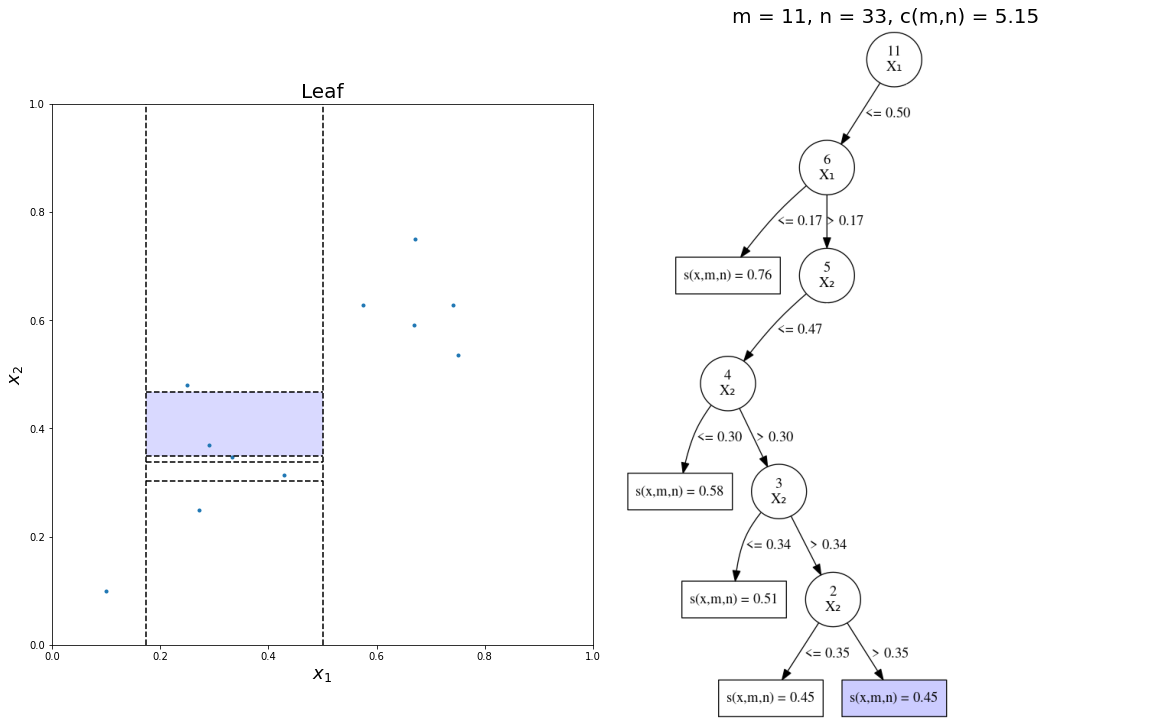

./plots/011


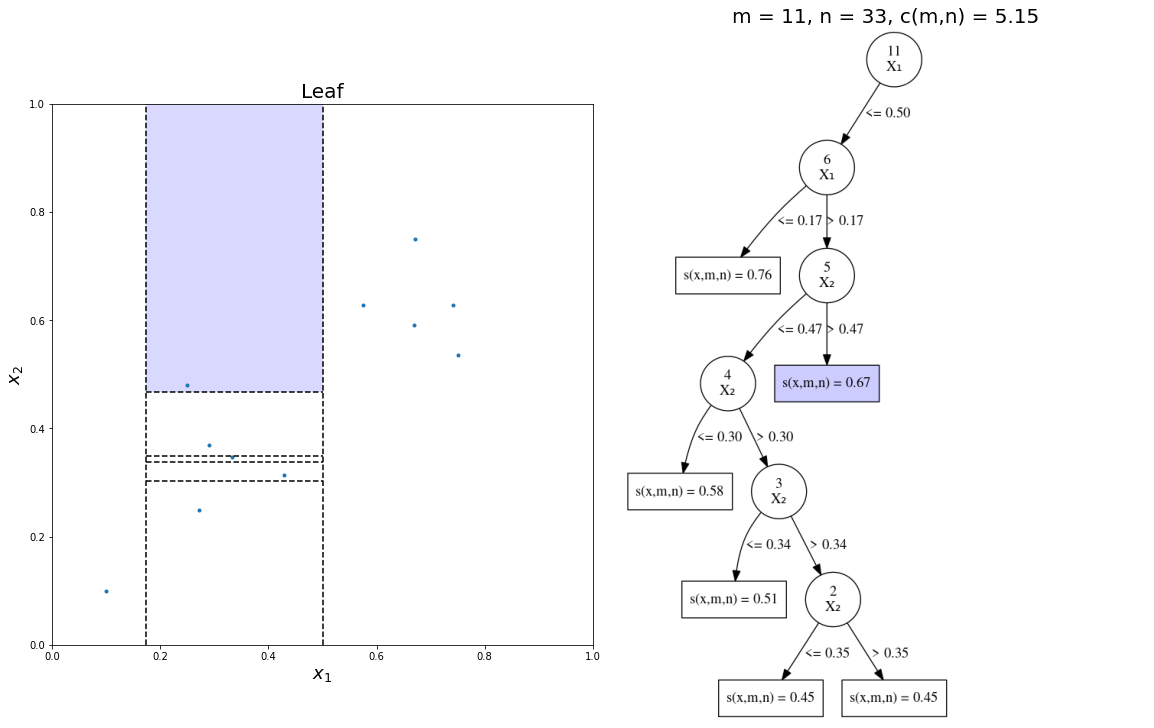

./plots/012


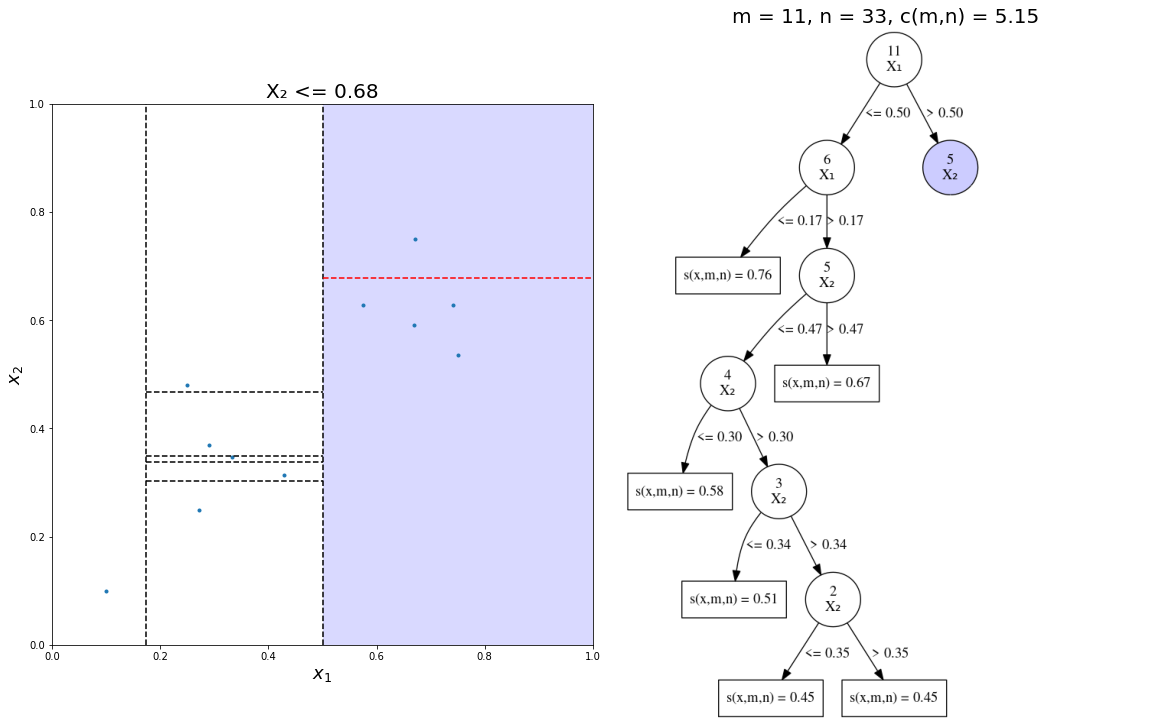

./plots/013


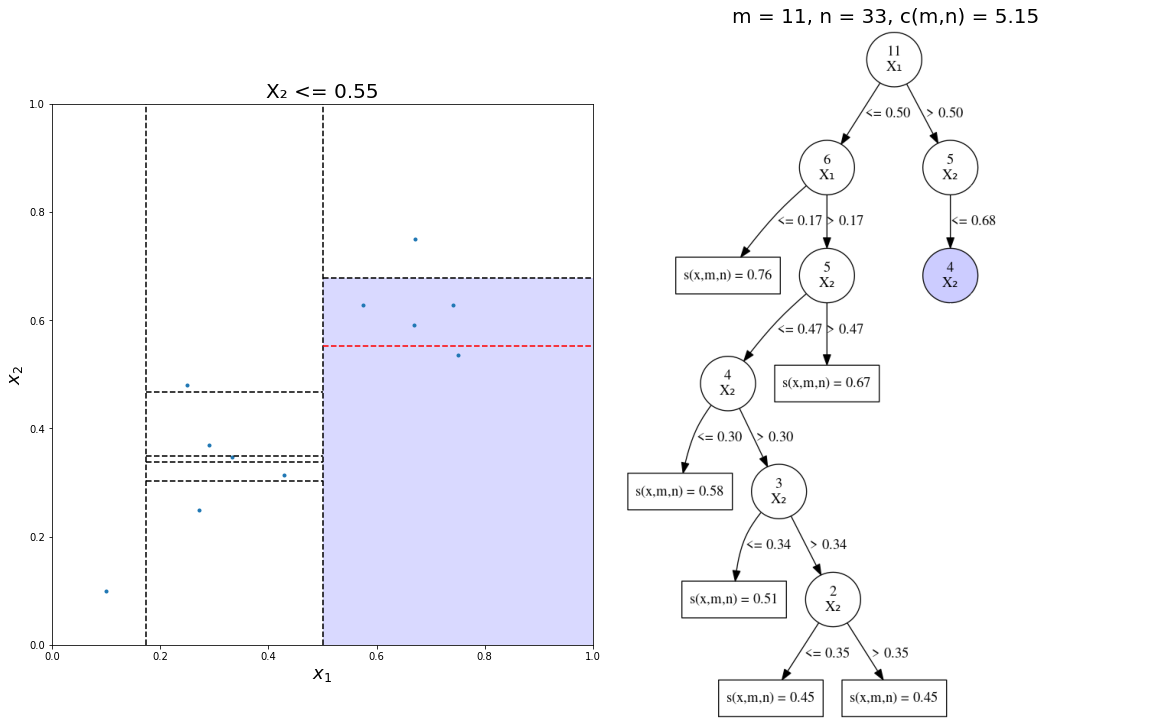

./plots/014


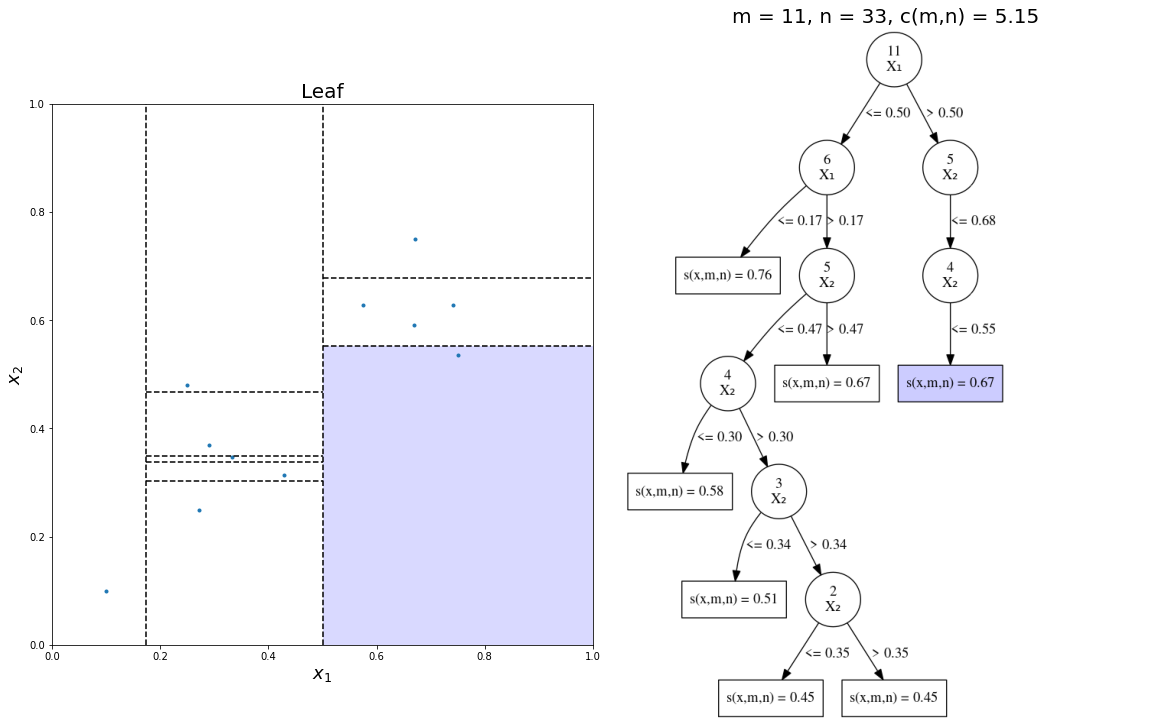

./plots/015


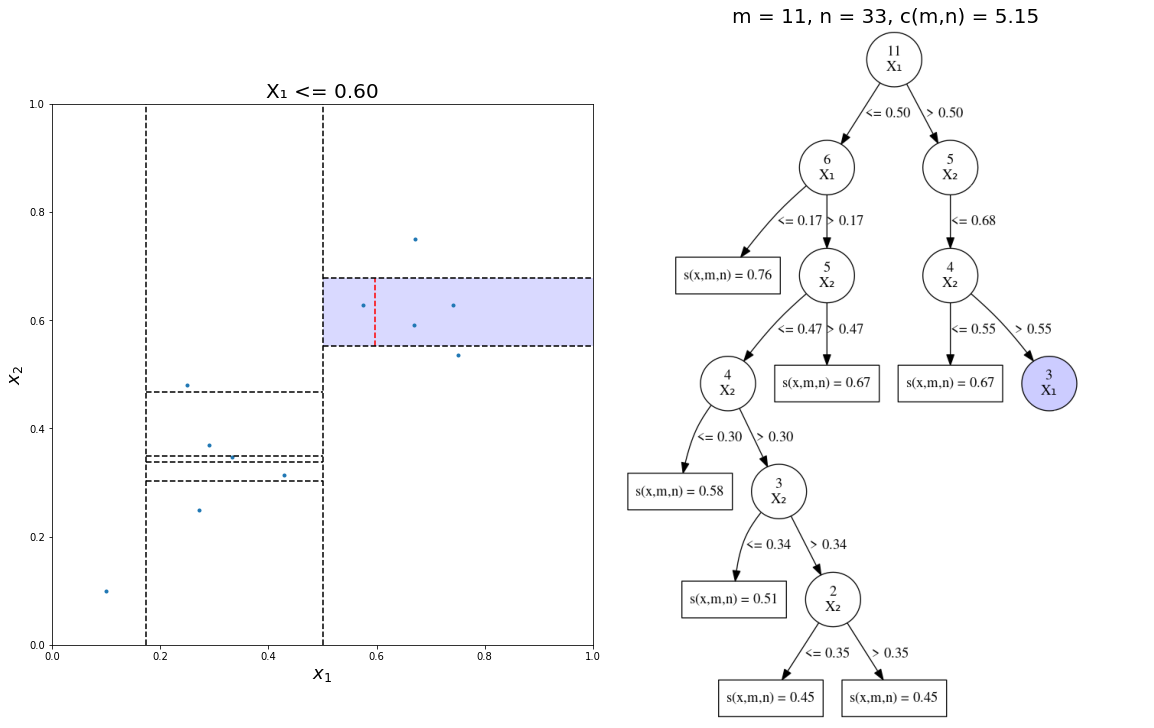

./plots/016


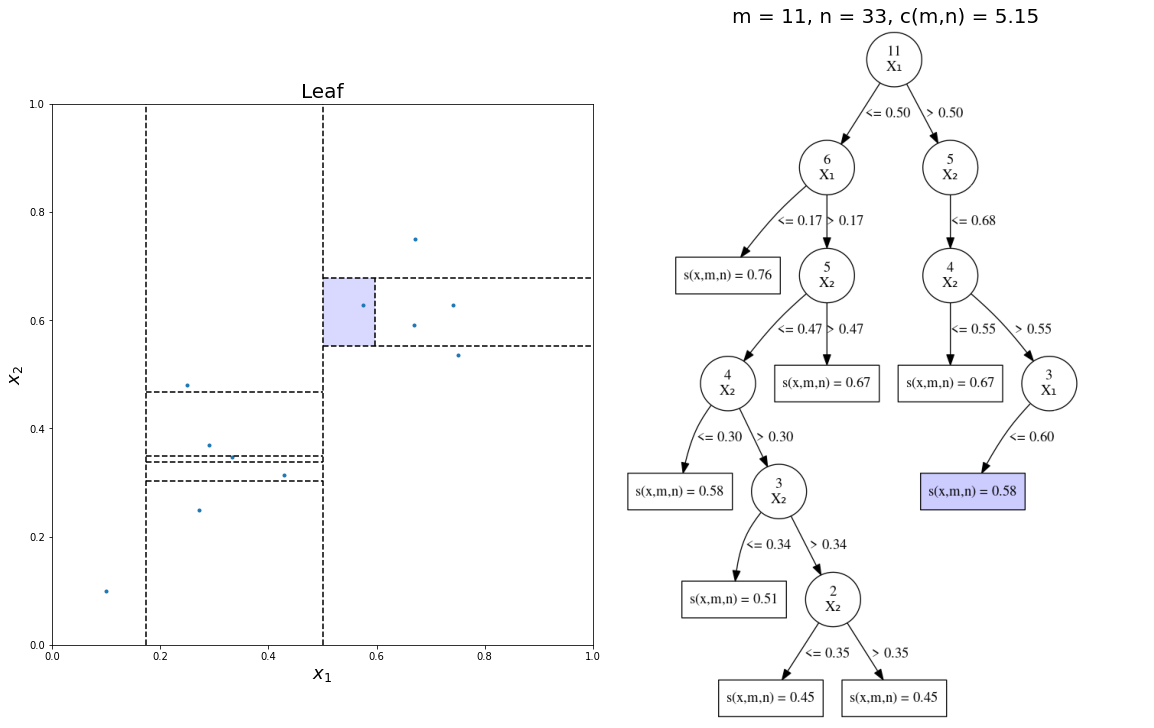

./plots/017


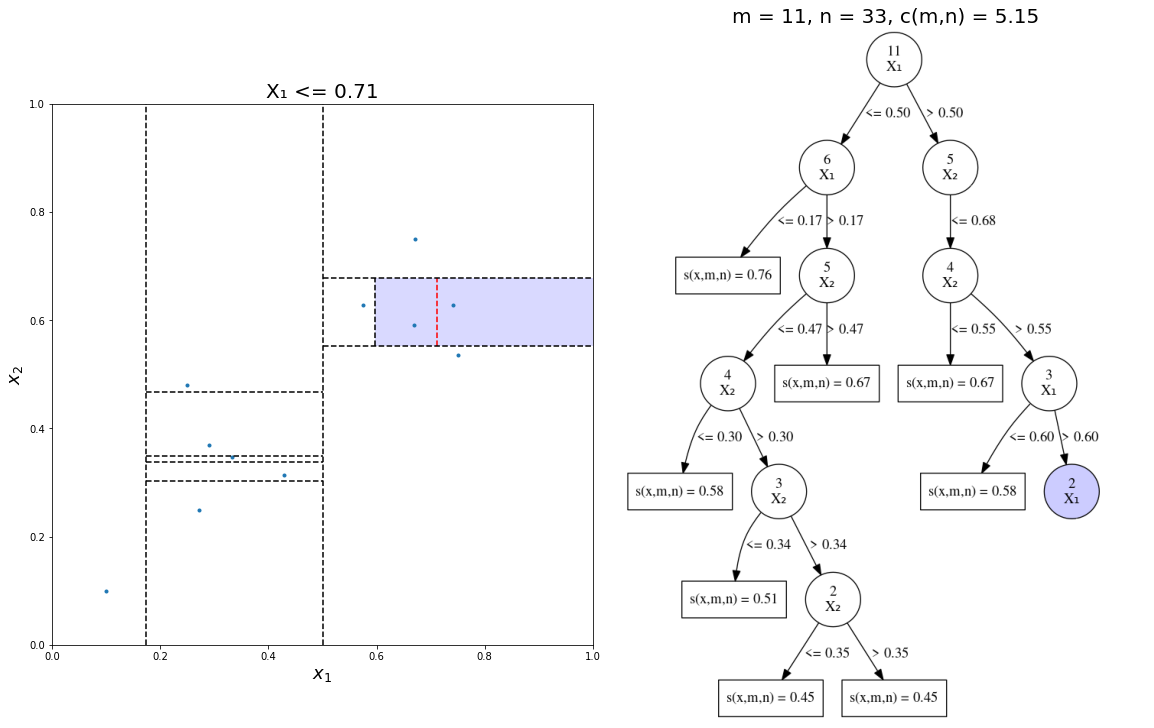

./plots/018


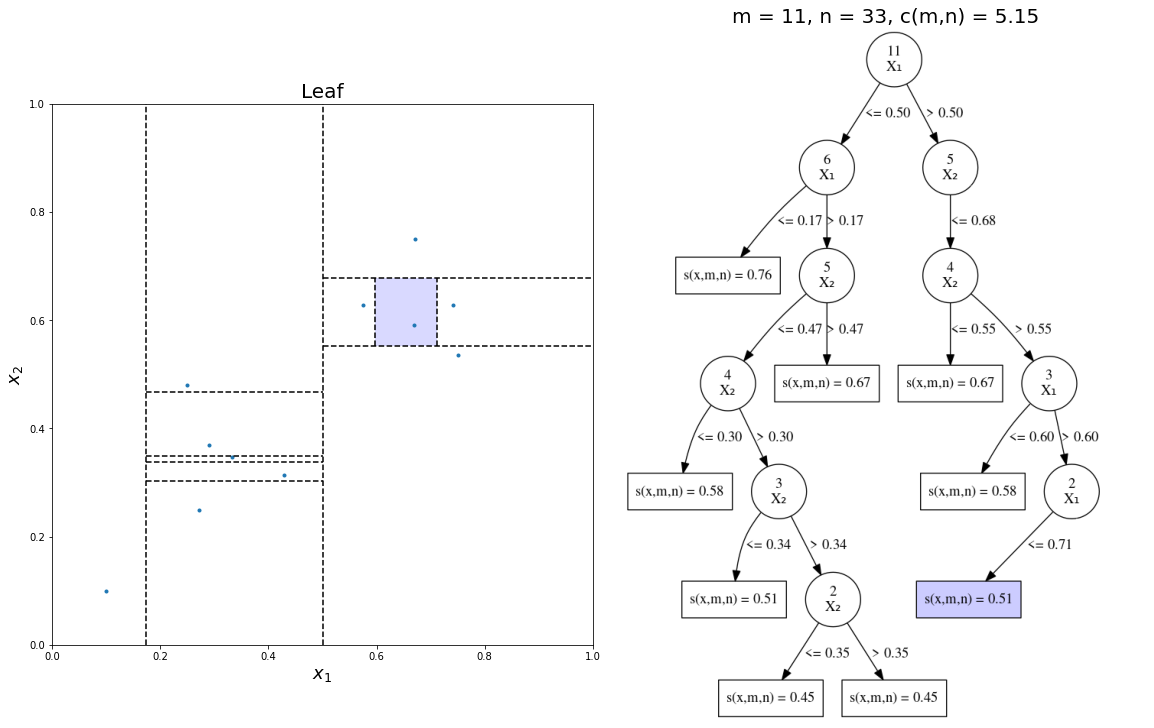

./plots/019


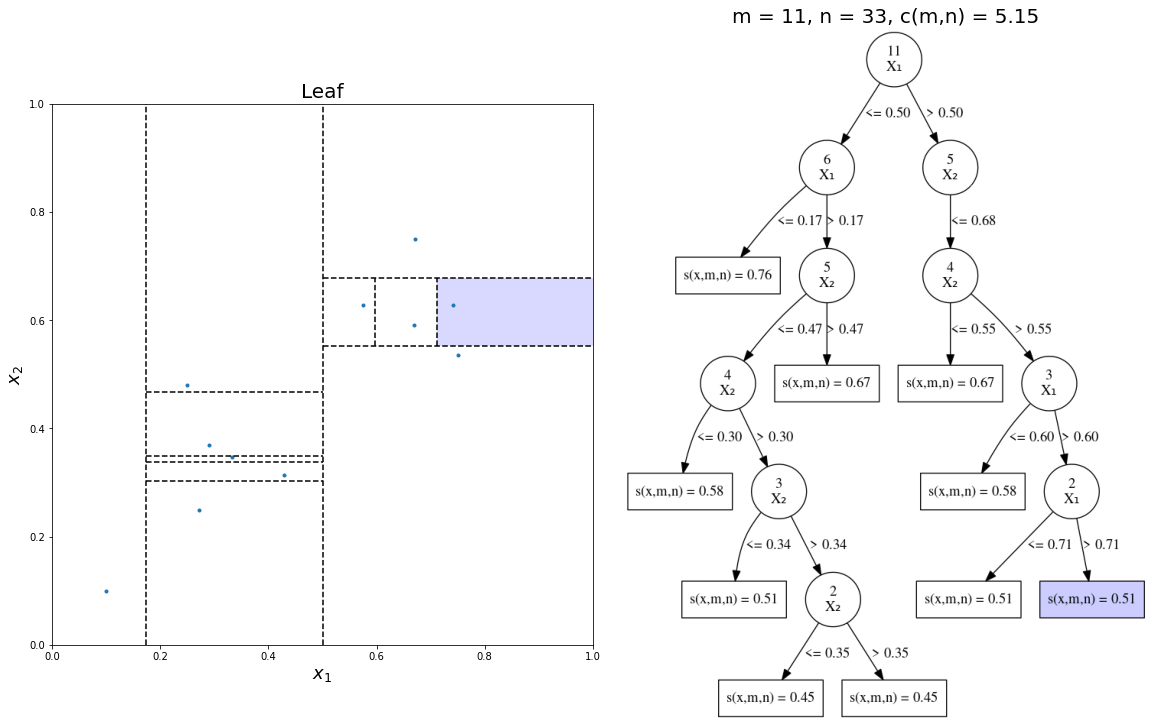

./plots/020


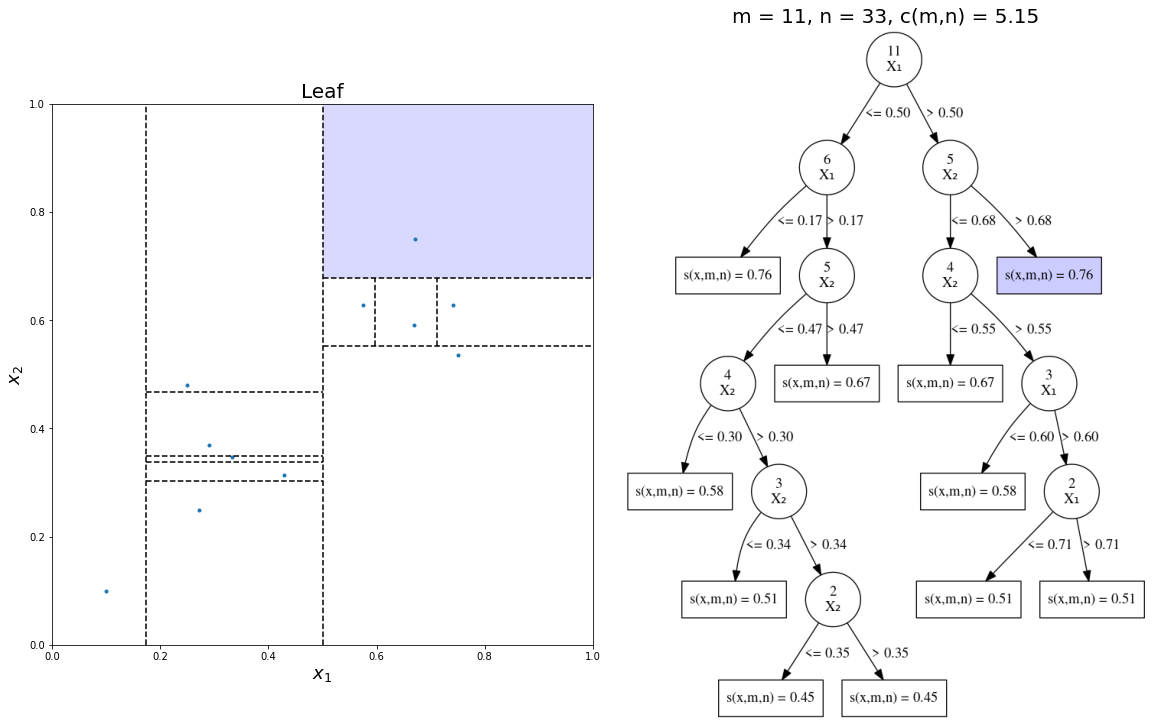

./plots/021


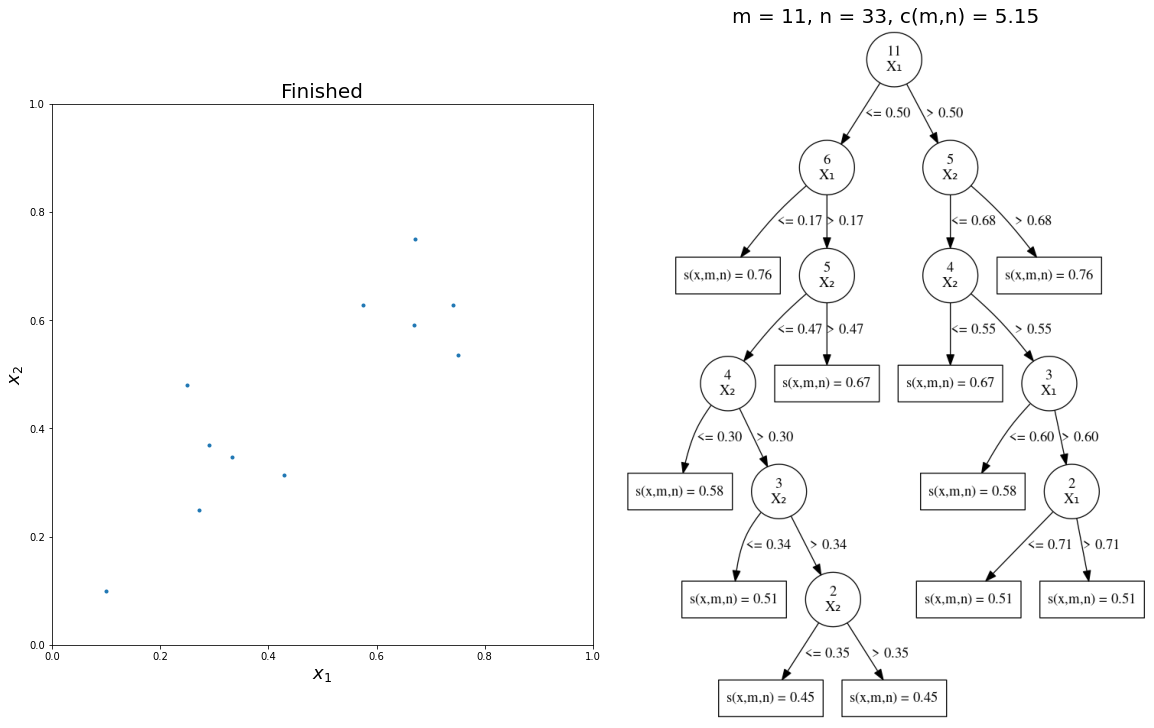

In [15]:
def _plot_data(XX, title="", vlines=[], hlines=[], last=None, region=None, ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig,ax = plt.subplots(figsize=(8,5))
    ax.scatter(*XX.T, marker=".", zorder=0)
    if region is not None:
        ax.add_patch(
            mpl.patches.Rectangle(
                region[0], *(region[1]-region[0]),
                facecolor = "blue",
                fill=True,
                lw=5,
                zorder=-1,
                alpha=0.15
            ),
        )
    for line in vlines:
        color = "red" if last == vlines and line == last[-1] else "black"
        ax.vlines(*line, color=color, linestyle="dashed", zorder=1)
    for line in hlines:
        color = "red" if last == hlines and line == last[-1] else "black"
        ax.hlines(*line, color=color, linestyle="dashed", zorder=1)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("$x_{1}$", fontsize=18)
    ax.set_ylabel("$x_{2}$", fontsize=18)
#     ax.xaxis.label.set_size(20)
#     ax.yaxis.label.set_size(20)
    ax.set_aspect("equal")
    if ax_is_none:
        plt.show()
        
def _plot_dot(X_full, X_sample, i_tree, hidden=set(), node_attrs=dict(), ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig,ax = plt.subplots(figsize=(8,5))
    dot = iTree2Digraph(i_tree, hidden=hidden, node_attrs=node_attrs)
    
    mm = len(X_sample)
    nn = len(X_full)
    cm = (2*(np.log(mm-1) + np.euler_gamma)) - (2*(mm-1)/nn)
    title = f"m = {mm}, n = {nn}, c(m,n) = {cm:0.2f}"
    
    svg = dot.pipe(format="png")
    fp = io.BytesIO(svg)
    image = PIL.Image.open(fp)
    ax.imshow(image)
#     ax.set_aspect(image.size[1]/image.size[0])
    ax.set_title(title, fontsize=20)
    ax.set_axis_off()
    ax.set_aspect("equal")
    if ax_is_none:
        plt.show()

def _plot_iteration(X_full, X_sample, i_tree, node_attrs=dict(), hidden=set(), title="", vlines=[], hlines=[], last=None, region=None, n_plots=0):
    filename = os.path.join(plots_dir, f"{n_plots:03d}")
    print(filename)
    fig = plt.figure(figsize=(16,10), constrained_layout=True)
    gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    
    ax = fig.add_subplot(gs[0,1])
    _plot_dot(X_full, X_sample, i_tree, hidden=hidden, node_attrs=node_attrs, ax=ax)
    
    ax = fig.add_subplot(gs[0,0])
    _plot_data(X_sample, title=title, vlines=vlines, hlines=hlines, last=last, region=region, ax=ax)
    
    plt.savefig(filename)
    plt.show()
    
def _plot_traverse(X_full, X_sample, i_tree, node_attrs, hidden, node, vlines, hlines, region, n_plots):
    hidden.remove(hex(id(node)))
    if node.split_index is not None:
        feature = node.features[node.split_index]
        split_value = node.split_value
        
        title = f"{feature} <= {split_value:0.2f}"
        if node.split_index == 0:
            vline = [split_value, region[0,1], region[1,1]]
            vlines.append(vline)
            last = vlines
        else:
            hline = [split_value, region[0,0], region[1,0]]
            hlines.append(hline)
            last = hlines
        node_attrs[hex(id(node))].update( dict(fillcolor="#0000ff33", style="filled") )
        _plot_iteration(X_full, X_sample, i_tree, node_attrs=node_attrs, hidden=hidden, title=title, vlines=vlines, hlines=hlines, last=last, region=region, n_plots=n_plots)
        node_attrs[hex(id(node))] = {
            key:value
            for key,value in node_attrs[hex(id(node))].items()
            if key not in {"fillcolor", "style"}
        }
        n_plots += 1
        
        tmp_region = region.copy()
        if node.split_index == 0:
            tmp_region[1,0] = split_value
        else:
            tmp_region[1,1] = split_value
        n_plots = _plot_traverse(X_full, X_sample, i_tree, node_attrs, hidden, node.left, vlines, hlines, tmp_region, n_plots)
        
        tmp_region = region.copy()
        if node.split_index == 0:
            tmp_region[0,0] = split_value
        else:
            tmp_region[0,1] = split_value
        n_plots = _plot_traverse(X_full, X_sample, i_tree, node_attrs, hidden, node.right, vlines, hlines, tmp_region, n_plots)
    else:
        node_attrs[hex(id(node))].update( dict(fillcolor="#0000ff33", style="filled") )
        _plot_iteration(X_full, X_sample, i_tree, node_attrs=node_attrs, hidden=hidden, title="Leaf", vlines=vlines, hlines=hlines, region=region, n_plots=n_plots)
        node_attrs[hex(id(node))] = {
            key:value
            for key,value in node_attrs[hex(id(node))].items()
            if key not in {"fillcolor", "style"}
        }
        n_plots += 1
    return n_plots

def work(i_tree, X_full, X_sample):
    mkdirs(plots_dir)
    
    node_attrs = defaultdict(dict)
    hidden = set()
    def _traverse(node, depth=0):
        hidden.add( hex(id(node)) )
        if node.split_index is not None:
            _traverse(node.left, depth+1)
            _traverse(node.right, depth+1)
            node_attrs[hex(id(node))] = dict(
                label=f"{node.count}\n{node.features[node.split_index]}"
            )
        else:
            mm = len(X_sample)
            nn = len(X_full)
            hh = depth
            cm = (2*(np.log(mm-1) + np.euler_gamma)) - (2*(mm-1)/nn)
            ss = np.power(2, -hh/cm)
            node_attrs[hex(id(node))] = dict(
                label=f"s(x,m,n) = {ss:0.2f}",
                shape="box"
            )
            
    _traverse(i_tree.root)
    
    vlines = list()
    hlines = list()
    region = np.asarray([[0.,0.],[1.,1.]])
    
    filename = os.path.join(plots_dir, "data.png")
    fig = plt.figure(figsize=(16,10), constrained_layout=True)
    gs = mpl.gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
    _plot_data(X_full, title="Full Data", ax=fig.add_subplot(gs[0]))
    _plot_data(X_sample, title="Sampled Data", ax=fig.add_subplot(gs[1]))
    plt.savefig(filename)
    plt.show()
    
    n_plots = _plot_traverse(
        X_full,
        X_sample,
        i_tree=i_tree,
        node_attrs=node_attrs,
        hidden=hidden,
        node=i_tree.root,
        vlines=vlines,
        hlines=hlines,
        region=region,
        n_plots=0
    )
    _plot_iteration(X_full, X_sample, i_tree, node_attrs=node_attrs, hidden=hidden, title="Finished", n_plots=n_plots)
    
work(i_tree, X_full, X_sample)